In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import collections
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from IPython.core.interactiveshell import InteractiveShell
import warnings

%matplotlib inline


In [2]:
target_names=['Non-Persistent', 'Persistent']

In [4]:
df= pd.read_csv('dataset.csv')

# **Data Understanding**

In [5]:
df.head()

Unnamed: 0 Ptid Persistency_Flag  Gender           Race     Ethnicity  \
0           0   P1       Persistent    Male      Caucasian  Not Hispanic   
1           1   P2   Non-Persistent    Male          Asian  Not Hispanic   
2           2   P3   Non-Persistent  Female  Other/Unknown      Hispanic   
3           3   P4   Non-Persistent  Female      Caucasian  Not Hispanic   
4           4   P5   Non-Persistent  Female      Caucasian  Not Hispanic   

    Region Age_Bucket        Ntm_Speciality Ntm_Specialist_Flag  ...  \
0     West        >75  GENERAL PRACTITIONER              Others  ...   
1     West      55-65  GENERAL PRACTITIONER              Others  ...   
2  Midwest      65-75  GENERAL PRACTITIONER              Others  ...   
3  Midwest        >75  GENERAL PRACTITIONER              Others  ...   
4  Midwest        >75  GENERAL PRACTITIONER              Others  ...   

  Risk_Family_History_Of_Osteoporosis Risk_Low_Calcium_Intake  \
0                                   N                       N   
1                                   N                       N   
2                                   N                       Y   
3                                   N                       N   
4                                   N                       N   

  Risk_Vitamin_D_Insufficiency  Risk_Poor_Health_Frailty  \
0                            N                         N   
1                            N                         N   
2                            N                         N   
3                            N                         N   
4                            N                         N   

  Risk_Excessive_Thinness Risk_Hysterectomy_Oophorectomy  \
0                       N                              N   
1                       N                              N   
2                       N                              N   
3                       N                              N   
4                       N                              N   

  Risk_Estrogen_Deficiency Risk_Immobilization Risk_Recurring_Falls  \
0                        N                   N                    N   
1                        N                   N                    N   
2                        N                   N                    N   
3                        N                   N                    N   
4                        N                   N                    N   

  Count_Of_Risks  
0              0  
1              0  
2              2  
3              1  
4              1  

[5 rows x 70 columns]

In [6]:
df.shape

(3424, 70)

In [7]:
df.dtypes

Unnamed: 0                         int64
Ptid                              object
Persistency_Flag                  object
Gender                            object
Race                              object
                                   ...  
Risk_Hysterectomy_Oophorectomy    object
Risk_Estrogen_Deficiency          object
Risk_Immobilization               object
Risk_Recurring_Falls              object
Count_Of_Risks                     int64
Length: 70, dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 70 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Unnamed: 0                                                          3424 non-null   int64 
 1   Ptid                                                                3424 non-null   object
 2   Persistency_Flag                                                    3424 non-null   object
 3   Gender                                                              3424 non-null   object
 4   Race                                                                3424 non-null   object
 5   Ethnicity                                                           3424 non-null   object
 6   Region                                                              3424 non-null   object
 7   Age_Bucket              

In [9]:
df.columns=[x.lower() for x in df.columns]

### **Analyzing dependency of variable (Before Transformation)**

In [10]:
classes=df['persistency_flag'].value_counts()
normal_share=round(classes[0]/df['persistency_flag'].count()*100,2)
fraud_share=round(classes[1]/df['persistency_flag'].count()*100, 2)
print("Non-Persistent : {} %".format(normal_share))
print("Persistent : {} %".format(fraud_share))

Non-Persistent : 62.35 %
Persistent : 37.65 %


In [11]:
cat_corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)[['persistency_flag']]
np.abs(cat_corr).sort_values(by=['persistency_flag'], ascending=False)

persistency_flag
persistency_flag                                            1.000000
dexa_during_rx                                              0.491823
dexa_freq_during_rx                                         0.395247
comorb_long_term_current_drug_therapy                       0.352760
comorb_encounter_for_screening_for_malignant_ne...          0.322320
...                                                              ...
risk_untreated_early_menopause                              0.005279
risk_family_history_of_osteoporosis                         0.003492
risk_osteogenesis_imperfecta                                0.002636
risk_segment_during_rx                                      0.000700
frag_frac_prior_ntm                                         0.000318

[70 rows x 1 columns]

## **Missing Values**

In [12]:

df.isnull().sum()

unnamed: 0                        0
ptid                              0
persistency_flag                  0
gender                            0
race                              0
                                 ..
risk_hysterectomy_oophorectomy    0
risk_estrogen_deficiency          0
risk_immobilization               0
risk_recurring_falls              0
count_of_risks                    0
Length: 70, dtype: int64

## **Outlier Analysis**

In [13]:
fig = px.histogram(df, x="dexa_freq_during_rx",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()

In [14]:
fig = px.histogram(df, x="count_of_risks",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()

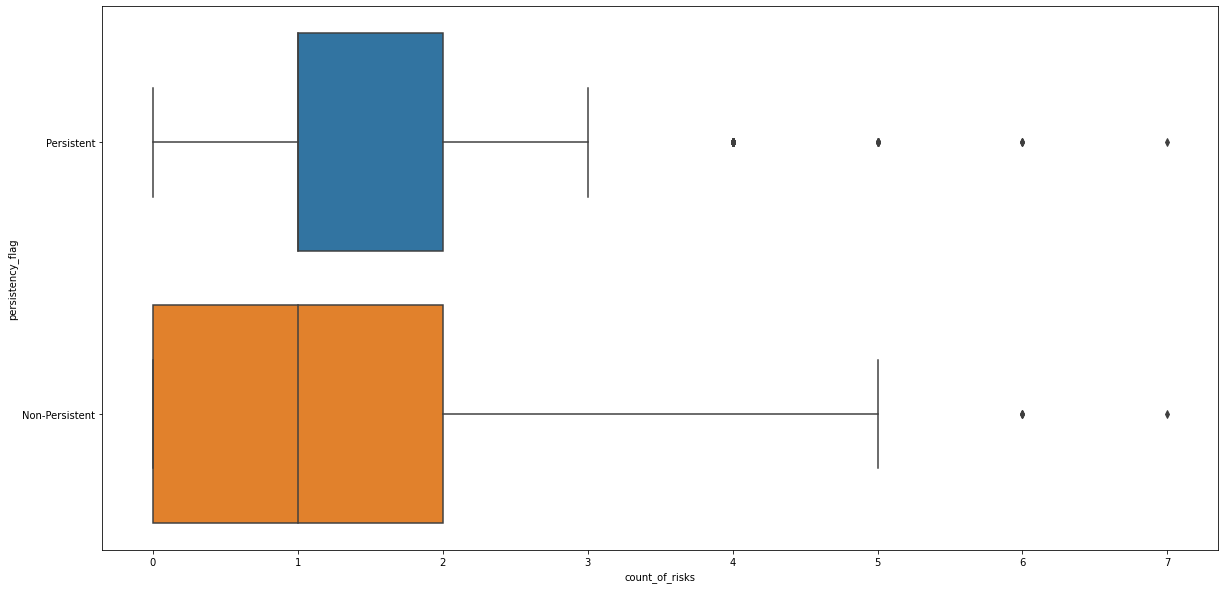

In [15]:
plt.figure(figsize=(20,10))
var ="count_of_risks"
sns.boxplot(x=var,y ="persistency_flag",data=df)

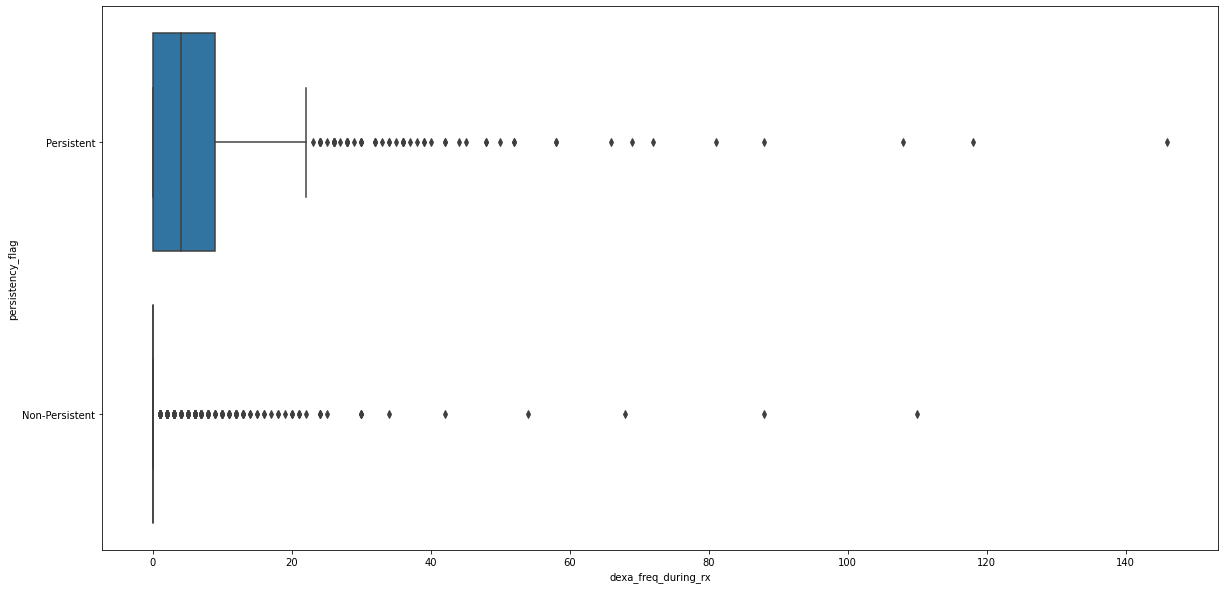

In [16]:
plt.figure(figsize=(20,10))
var ="dexa_freq_during_rx"
sns.boxplot(x=var,y ="persistency_flag",data=df)

In [17]:
print("Count of risks skweness: ",df["count_of_risks"].skew())
print("Count of risks Kurtosis: ",df["count_of_risks"].kurt())

## Data shows a moderate positive skewed data on this column and fairly platykurtic
## Means the data has little outliers

Count of risks skweness:  0.8797905232898707
Count of risks Kurtosis:  0.9004859968892842


In [18]:
print("dexa_freq_during_rx skweness: ",df["dexa_freq_during_rx"].skew())
print("dexa_freq_during_rx Kurtosis: ",df["dexa_freq_during_rx"].kurt())
## very high positive skewed and also with very high kurtosis(Platykurtic)
## This suggests Presence of alot of outliers.

dexa_freq_during_rx skweness:  6.8087302112992285
dexa_freq_during_rx Kurtosis:  74.75837754795428


In [19]:
#standardizing dexa_freq_during_rx df
dexa_scaled = StandardScaler().fit_transform(df['dexa_freq_during_rx'][:,np.newaxis]);
low_range = dexa_scaled[dexa_scaled[:,0].argsort()][:10]
high_range= dexa_scaled[dexa_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]
 [-0.3707352]]

outer range (high) of the distribution:
[[ 7.98784109]
 [ 8.11076133]
 [ 8.47952205]
 [ 9.58580421]
 [10.44624589]
 [10.44624589]
 [12.90465068]
 [13.15049116]
 [14.13385307]
 [17.57561978]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [20]:
scaler = RobustScaler()
df['dexa_freq_during_rx'] = scaler.fit_transform(df['dexa_freq_during_rx'].values.reshape(-1,1))

In [21]:
scaler = RobustScaler()
df['count_of_risks'] = scaler.fit_transform(df['count_of_risks'].values.reshape(-1,1))

In [22]:
''' Detection '''
# IQR
Q1 = np.percentile(df['dexa_freq_during_rx'], 25, 
                   interpolation = 'midpoint') 
  
Q3 = np.percentile(df['dexa_freq_during_rx'], 75,
                   interpolation = 'midpoint') 
IQR = Q3 - Q1 
  
print("Old Shape: ", df.shape) 
  
# Upper bound
upper = np.where(df['dexa_freq_during_rx'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['dexa_freq_during_rx'] <= (Q1-1.5*IQR))
  
print("lower",lower[0])
print("Upper",upper[0])

''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

print("New Shape: ", df.shape)

df = df.reset_index(drop=True)

Old Shape:  (3424, 70)
lower []
Upper [  32   33   62   65   89  101  110  116  164  180  186  194  198  201
  217  241  246  256  264  282  292  303  327  340  349  358  368  369
  373  378  382  390  415  417  426  433  448  457  462  464  480  495
  496  497  505  514  517  541  545  549  563  575  588  589  592  599
  603  605  613  640  646  651  653  656  657  678  684  688  700  705
  710  711  726  728  729  730  759  760  764  765  785  786  804  814
  823  834  847  849  864  870  873  885  909  915  925  926  930  937
  946  978  982  991  994 1006 1008 1016 1042 1061 1073 1074 1076 1113
 1118 1119 1128 1134 1141 1148 1151 1196 1240 1265 1267 1270 1272 1273
 1280 1283 1286 1291 1315 1359 1360 1363 1365 1370 1372 1396 1398 1404
 1448 1474 1513 1524 1533 1539 1546 1550 1554 1555 1564 1566 1570 1576
 1599 1628 1641 1642 1647 1654 1662 1671 1691 1703 1724 1732 1734 1746
 1752 1773 1782 1783 1788 1793 1803 1815 1826 1833 1834 1836 1838 1848
 1852 1854 1870 1876 1895 1901 1904 190

In [23]:
''' Detection '''
# IQR
Q1 = np.percentile(df['count_of_risks'], 25, 
                   interpolation = 'midpoint') 
  
Q3 = np.percentile(df['count_of_risks'], 75,
                   interpolation = 'midpoint') 
IQR = Q3 - Q1 
  
print("Old Shape: ", df.shape) 
  
# Upper bound
upper = np.where(df['count_of_risks'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['count_of_risks'] <= (Q1-1.5*IQR))
  
print("lower",lower[0])
print("Upper",upper[0])

''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

print("New Shape: ", df.shape) 

df = df.reset_index(drop=True)

Old Shape:  (2964, 70)
lower []
Upper [ 281  318  327  507  655  665  678  705  733  952 1001 1126 1590 1624
 1836 2227 2234 2450 2611 2702 2755 2888]
New Shape:  (2942, 70)


## **Describe Data**

In [25]:
#distribution of categorical features
df.describe(include=['O'])

ptid persistency_flag  gender       race     ethnicity   region  \
count   2942             2942    2942       2942          2942     2942   
unique  2942                2       2          4             3        5   
top       P1   Non-Persistent  Female  Caucasian  Not Hispanic  Midwest   
freq       1             2047    2769       2701          2784     1210   

       age_bucket        ntm_speciality ntm_specialist_flag  \
count        2942                  2942                2942   
unique          4                    35                   2   
top           >75  GENERAL PRACTITIONER              Others   
freq         1262                  1345                1774   

            ntm_speciality_bucket  ... risk_chronic_liver_disease  \
count                        2942  ...                       2942   
unique                          3  ...                          2   
top     OB/GYN/Others/PCP/Unknown  ...                          N   
freq                         1855  ...                       2928   

       risk_family_history_of_osteoporosis risk_low_calcium_intake  \
count                                 2942                    2942   
unique                                   2                       2   
top                                      N                       N   
freq                                  2650                    2906   

       risk_vitamin_d_insufficiency risk_poor_health_frailty  \
count                          2942                     2942   
unique                            2                        2   
top                               N                        N   
freq                           1558                     2788   

       risk_excessive_thinness risk_hysterectomy_oophorectomy  \
count                     2942                           2942   
unique                       2                              2   
top                          N                              N   
freq                      2881                           2897   

       risk_estrogen_deficiency risk_immobilization risk_recurring_falls  
count                      2942                2942                 2942  
unique                        2                   2                    2  
top                           N                   N                    N  
freq                       2933                2930                 2887  

[4 rows x 67 columns]

In [26]:
df.groupby(['persistency_flag']).mean().T

persistency_flag     Non-Persistent   Persistent
unnamed: 0              1713.486077  1639.418994
dexa_freq_during_rx        0.085491     0.662570
count_of_risks             0.074744     0.155866

In [27]:
df.groupby(['gender']).mean().T

gender                    Female         Male
unnamed: 0           1676.537378  1921.699422
dexa_freq_during_rx     0.263874     0.215800
count_of_risks          0.099494     0.098266

In [28]:
df.groupby(['race']).mean()

unnamed: 0  dexa_freq_during_rx  count_of_risks
race                                                              
African American  2098.065217             0.246377        0.168478
Asian             2064.434783             0.135266        0.021739
Caucasian         1667.487597             0.266445        0.098297
Other/Unknown     1692.925000             0.204167        0.125000

In [29]:
df.groupby(['ethnicity']).mean().T

ethnicity               Hispanic  Not Hispanic      Unknown
unnamed: 0           1933.790123   1678.442888  1887.844156
dexa_freq_during_rx     0.279835      0.260417     0.264069
count_of_risks          0.265432      0.097342     0.000000

In [30]:
df.groupby(['age_bucket']).mean().T

age_bucket                 55-65        65-75          <55          >75
unnamed: 0           1923.271704  1635.498904  1874.232877  1595.323296
dexa_freq_during_rx     0.242229     0.297880     0.273973     0.242208
count_of_risks          0.118167     0.097039     0.089041     0.093106

In [31]:
df.groupby(['ntm_speciality']).mean().T

ntm_speciality        CARDIOLOGY  CLINICAL NURSE SPECIALIST  \
unnamed: 0           3013.952381                     2112.0   
dexa_freq_during_rx     0.285714                        0.0   
count_of_risks          0.380952                       -0.5   

ntm_speciality       EMERGENCY MEDICINE  ENDOCRINOLOGY  GASTROENTEROLOGY  \
unnamed: 0                       1492.0    1889.024862            2088.0   
dexa_freq_during_rx                 0.0       0.392265               0.0   
count_of_risks                      0.0       0.279006               0.0   

ntm_speciality       GENERAL PRACTITIONER  GERIATRIC MEDICINE  \
unnamed: 0                    1365.044610             3016.50   
dexa_freq_during_rx              0.212887                1.00   
count_of_risks                   0.049442                0.75   

ntm_speciality       HEMATOLOGY & ONCOLOGY  HOSPICE AND PALLIATIVE MEDICINE  \
unnamed: 0                     2168.500000                          2739.50   
dexa_freq_during_rx               0.111111                             0.00   
count_of_risks                   -0.041667                            -0.25   

ntm_speciality       HOSPITAL MEDICINE  ...  PODIATRY  \
unnamed: 0                      2361.0  ...    1493.0   
dexa_freq_during_rx                0.0  ...       0.0   
count_of_risks                    -0.5  ...      -0.5   

ntm_speciality       PSYCHIATRY AND NEUROLOGY  PULMONARY MEDICINE  RADIOLOGY  \
unnamed: 0                         519.666667          956.571429     1376.0   
dexa_freq_during_rx                  0.666667            0.428571        0.0   
count_of_risks                       0.500000            0.714286        0.0   

ntm_speciality       RHEUMATOLOGY  SURGERY AND SURGICAL SPECIALTIES  \
unnamed: 0            2230.518664                          993.5000   
dexa_freq_during_rx      0.221349                            0.2500   
count_of_risks           0.185658                            0.1875   

ntm_speciality       TRANSPLANT SURGERY      UROLOGY      Unknown  \
unnamed: 0                       1862.5  2370.965517  1982.685512   
dexa_freq_during_rx                 0.0     0.149425     0.207303   
count_of_risks                     -0.5    -0.034483     0.042403   

ntm_speciality       VASCULAR SURGERY  
unnamed: 0                     2965.5  
dexa_freq_during_rx               0.0  
count_of_risks                    0.0  

[3 rows x 35 columns]

In [32]:
df.groupby(['ntm_specialist_flag']).mean().T

ntm_specialist_flag       Others   Specialist
unnamed: 0           1508.383878  1968.247432
dexa_freq_during_rx     0.215145     0.330765
count_of_risks          0.056370     0.164812

In [33]:
df.groupby(['ntm_speciality_bucket']).mean().T

ntm_speciality_bucket  Endo/Onc/Uro  OB/GYN/Others/PCP/Unknown        Rheum
unnamed: 0              1757.301038                1522.227493  2230.518664
dexa_freq_during_rx        0.442907                   0.215274     0.221349
count_of_risks             0.170415                   0.053639     0.185658

In [34]:
df.groupby(['ntm_speciality_bucket']).mean().T

ntm_speciality_bucket  Endo/Onc/Uro  OB/GYN/Others/PCP/Unknown        Rheum
unnamed: 0              1757.301038                1522.227493  2230.518664
dexa_freq_during_rx        0.442907                   0.215274     0.221349
count_of_risks             0.170415                   0.053639     0.185658

In [35]:
df.groupby(['risk_chronic_liver_disease']).mean().T

risk_chronic_liver_disease            N            Y
unnamed: 0                  1691.232240  1632.714286
dexa_freq_during_rx            0.260132     0.452381
count_of_risks                 0.096482     0.714286

In [36]:
df.groupby(['risk_family_history_of_osteoporosis']).mean().T

risk_family_history_of_osteoporosis            N            Y
unnamed: 0                           1682.163774  1770.726027
dexa_freq_during_rx                     0.258113     0.287671
count_of_risks                          0.045283     0.590753

In [37]:
df.groupby(['risk_low_calcium_intake']).mean().T

risk_low_calcium_intake            N            Y
unnamed: 0               1689.338266  1821.361111
dexa_freq_during_rx         0.261069     0.259259
count_of_risks              0.090502     0.819444

In [38]:
df.groupby(['risk_vitamin_d_insufficiency']).mean().T

risk_vitamin_d_insufficiency            N            Y
unnamed: 0                    1643.207959  1744.702312
dexa_freq_during_rx              0.223363     0.303468
count_of_risks                  -0.175866     0.409321

In [39]:
df.groupby(['risk_excessive_thinness']).mean().T

risk_excessive_thinness            N            Y
unnamed: 0               1685.813606  1933.721311
dexa_freq_during_rx         0.261946     0.218579
count_of_risks              0.085908     0.737705

In [40]:
df.groupby(['risk_hysterectomy_oophorectomy']).mean().T

risk_hysterectomy_oophorectomy            N            Y
unnamed: 0                      1687.946151  1884.577778
dexa_freq_during_rx                0.261650     0.222222
count_of_risks                     0.089748     0.722222

In [41]:
df.groupby(['risk_estrogen_deficiency']).mean().T

risk_estrogen_deficiency            N            Y
unnamed: 0                1691.543130  1498.888889
dexa_freq_during_rx          0.261052     0.259259
count_of_risks               0.097682     0.666667

In [42]:
df.groupby(['risk_immobilization']).mean().T

risk_immobilization            N            Y
unnamed: 0           1688.938567  2183.000000
dexa_freq_during_rx     0.262002     0.027778
count_of_risks          0.096416     0.833333

In [43]:

df.groupby(['risk_recurring_falls']).mean().T

risk_recurring_falls            N            Y
unnamed: 0            1688.354693  1827.381818
dexa_freq_during_rx      0.259901     0.321212
count_of_risks           0.087634     0.718182

# **Data Wrangling , Transformation and Standardization**

In [44]:
df = df.drop(['ptid'], axis=1)

In [45]:
mapper = {'N': 0, 'Y':1}
df = df.replace(mapper)

In [46]:
df['persistency_flag'] = df['persistency_flag'].replace(['Non-Persistent', 'Persistent'],[0, 1])
df.head()

unnamed: 0  persistency_flag  gender           race     ethnicity   region  \
0           0                 1    Male      Caucasian  Not Hispanic     West   
1           1                 0    Male          Asian  Not Hispanic     West   
2           2                 0  Female  Other/Unknown      Hispanic  Midwest   
3           3                 0  Female      Caucasian  Not Hispanic  Midwest   
4           4                 0  Female      Caucasian  Not Hispanic  Midwest   

  age_bucket        ntm_speciality ntm_specialist_flag  \
0        >75  GENERAL PRACTITIONER              Others   
1      55-65  GENERAL PRACTITIONER              Others   
2      65-75  GENERAL PRACTITIONER              Others   
3        >75  GENERAL PRACTITIONER              Others   
4        >75  GENERAL PRACTITIONER              Others   

       ntm_speciality_bucket  ...  risk_family_history_of_osteoporosis  \
0  OB/GYN/Others/PCP/Unknown  ...                                    0   
1  OB/GYN/Others/PCP/Unknown  ...                                    0   
2  OB/GYN/Others/PCP/Unknown  ...                                    0   
3  OB/GYN/Others/PCP/Unknown  ...                                    0   
4  OB/GYN/Others/PCP/Unknown  ...                                    0   

   risk_low_calcium_intake  risk_vitamin_d_insufficiency  \
0                        0                             0   
1                        0                             0   
2                        1                             0   
3                        0                             0   
4                        0                             0   

   risk_poor_health_frailty  risk_excessive_thinness  \
0                         0                        0   
1                         0                        0   
2                         0                        0   
3                         0                        0   
4                         0                        0   

   risk_hysterectomy_oophorectomy risk_estrogen_deficiency  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   

  risk_immobilization risk_recurring_falls count_of_risks  
0                   0                    0           -0.5  
1                   0                    0           -0.5  
2                   0                    0            0.5  
3                   0                    0            0.0  
4                   0                    0            0.0  

[5 rows x 69 columns]

### **Analyzing dependency of variable (After Transformation)**

In [47]:
np.abs(df.corr()).sort_values(by=['persistency_flag'], ascending=False)

unnamed: 0  \
persistency_flag                                      0.033908   
dexa_freq_during_rx                                   0.043708   
dexa_during_rx                                        0.039931   
comorb_long_term_current_drug_therapy                 0.051437   
comorb_encounter_for_screening_for_malignant_ne...    0.005522   
comorb_encounter_for_immunization                     0.056192   
comorb_encntr_for_general_exam_w_o_complaint,_s...    0.071712   
concom_systemic_corticosteroids_plain                 0.001857   
concom_viral_vaccines                                 0.029387   
comorb_other_disorders_of_bone_density_and_stru...    0.004143   
concom_anaesthetics_general                           0.035419   
concom_cephalosporins                                 0.001054   
comorb_other_joint_disorder_not_elsewhere_class...    0.038658   
gluco_record_during_rx                                0.015618   
comorb_gastro_esophageal_reflux_disease               0.001450   
concom_macrolides_and_similar_types                   0.017867   
comorb_personal_history_of_other_diseases_and_c...    0.062746   
concom_narcotics                                      0.033475   
concom_broad_spectrum_penicillins                     0.008397   
concom_fluoroquinolones                               0.033057   
comorb_dorsalgia                                      0.022013   
comorb_encntr_for_oth_sp_exam_w_o_complaint_sus...    0.077974   
comorb_personal_history_of_malignant_neoplasm         0.006174   
comorb_vitamin_d_deficiency                           0.060586   
comorb_disorders_of_lipoprotein_metabolism_and_...    0.046983   
comorb_osteoporosis_without_current_pathologica...    0.026532   
idn_indicator                                         0.219046   
concom_cholesterol_and_triglyceride_regulating_...    0.008783   
risk_smoking_tobacco                                  0.078019   
concom_anti_depressants_and_mood_stabilisers          0.010036   
frag_frac_during_rx                                   0.060410   
injectable_experience_during_rx                       0.095779   
count_of_risks                                        0.020277   
risk_vitamin_d_insufficiency                          0.050408   
risk_rheumatoid_arthritis                             0.008757   
risk_poor_health_frailty                              0.009102   
risk_untreated_chronic_hypogonadism                   0.053267   
risk_immobilization                                   0.031334   
unnamed: 0                                            1.000000   
risk_chronic_malnutrition_or_malabsorption            0.014086   
risk_chronic_liver_disease                            0.004007   
risk_excessive_thinness                               0.035151   
risk_estrogen_deficiency                              0.010587   
risk_recurring_falls                                  0.018737   
risk_untreated_chronic_hyperthyroidism                0.030909   
risk_family_history_of_osteoporosis                   0.026349   
risk_hysterectomy_oophorectomy                        0.024013   
risk_patient_parent_fractured_their_hip               0.043253   
risk_low_calcium_intake                               0.014443   
risk_type_1_insulin_dependent_diabetes                0.006682   
frag_frac_prior_ntm                                   0.074663   
risk_untreated_early_menopause                        0.022641   
gluco_record_prior_ntm                                0.001707   
risk_osteogenesis_imperfecta                          0.009666   

                                                    persistency_flag  \
persistency_flag                                            1.000000   
dexa_freq_during_rx                                         0.414876   
dexa_during_rx                                              0.374966   
comorb_long_term_current_drug_therapy                       0.342776   
comorb_encounter_for_screening_for_malignant_ne...          0

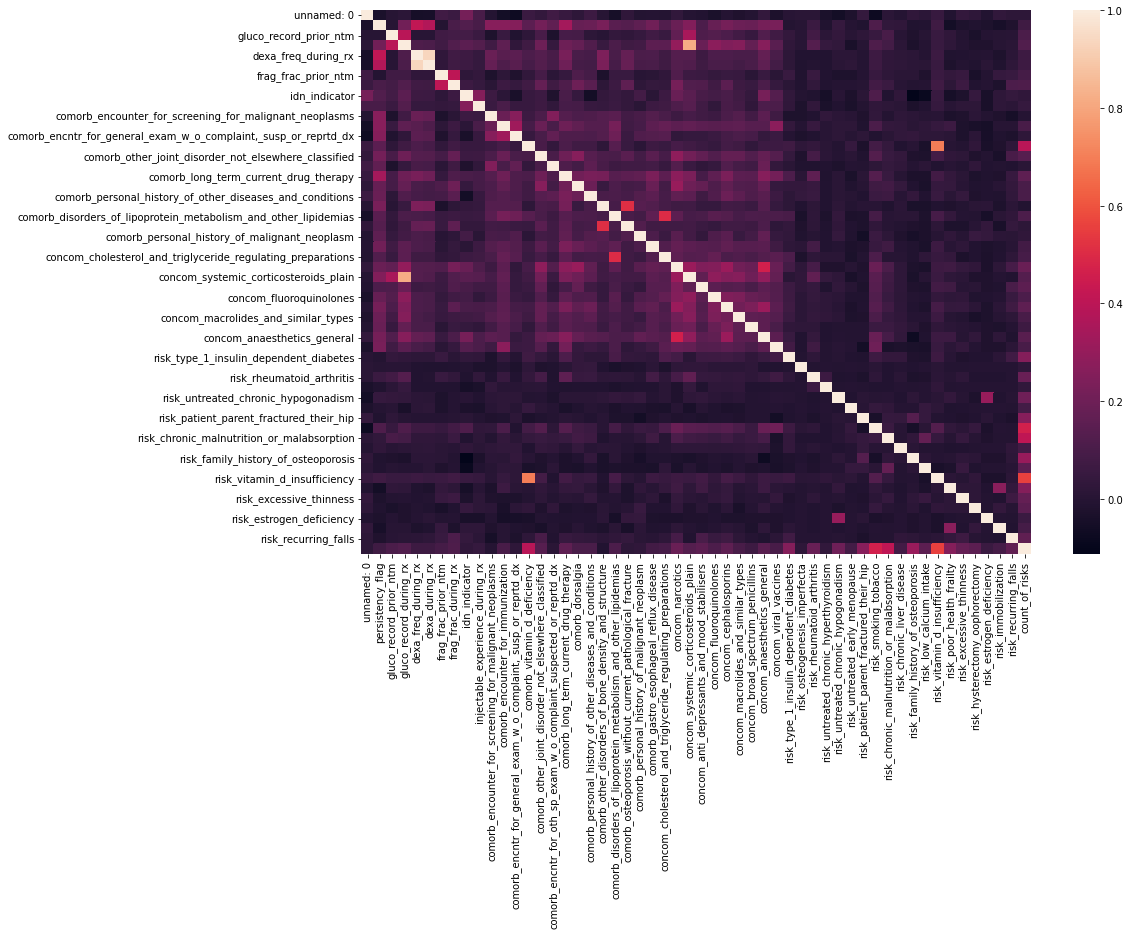

In [48]:
plt.subplots(figsize=(15,10))
sns.heatmap(df.corr())

### *Creating Dummy values*

In [49]:
X=df.drop(['persistency_flag'],axis=1)
y=df['persistency_flag']

X = pd.get_dummies(X)
X.columns=[x.lower() for x in X.columns]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3, stratify=y)

In [50]:
df_train = X_train.copy()
df_train['persistency_flag'] = y_train
df_train.head()

unnamed: 0  gluco_record_prior_ntm  gluco_record_during_rx  \
1493        1666                       1                       1   
1375        1531                       0                       0   
1217        1362                       1                       1   
1157        1299                       1                       1   
2766        3234                       0                       0   

      dexa_freq_during_rx  dexa_during_rx  frag_frac_prior_ntm  \
1493                  0.0               0                    0   
1375                  0.0               0                    0   
1217                  0.0               0                    0   
1157                  0.0               0                    0   
2766                  0.0               0                    1   

      frag_frac_during_rx  idn_indicator  injectable_experience_during_rx  \
1493                    0              0                                1   
1375                    0              1                                0   
1217                    0              0                                1   
1157                    0              1                                1   
2766                    0              1                                1   

      comorb_encounter_for_screening_for_malignant_neoplasms  ...  \
1493                                                  1       ...   
1375                                                  0       ...   
1217                                                  0       ...   
1157                                                  0       ...   
2766                                                  0       ...   

      change_t_score_no change  change_t_score_unknown  \
1493                         1                       0   
1375                         0                       1   
1217                         1                       0   
1157                         0                       0   
2766                         1                       0   

      change_t_score_worsened  change_risk_segment_improved  \
1493                        0                             0   
1375                        0                             0   
1217                        0                             0   
1157                        1                             0   
2766                        0                             0   

      change_risk_segment_no change  change_risk_segment_unknown  \
1493                              1                            0   
1375                              0                            1   
1217                              0                            0   
1157                              0                            0   
2766                              0                            1   

      change_risk_segment_worsened  adherent_flag_adherent  \
1493                             0                       1   
1375                             0                       1   
1217                             1                       0   
1157                             1                       1   
2766                             0                       1   

      adherent_flag_non-adherent  persistency_flag  
1493                           0                 1  
1375                           0                 0  
1217                           1                 0  
1157                           0                 1  
2766                           0                 0  

[5 rows x 132 columns]

### *Come Imbalanced dataset*

In [51]:
classes=df_train['persistency_flag'].value_counts()
normal_share=round(classes[0]/df_train['persistency_flag'].count()*100,2)
fraud_share=round(classes[1]/df_train['persistency_flag'].count()*100, 2)
print("Non-Persistent : {} %".format(normal_share))
print("Persistent : {} %".format(fraud_share))

Non-Persistent : 69.6 %
Persistent : 30.4 %


In [52]:
fig = px.histogram(df_train, x="persistency_flag", color="persistency_flag", title="Persistent class histogram")
fig.show()

### *Upsampling*

In [53]:
# Upsampling
df_minority_upsampled = resample(df_train[df_train['persistency_flag'] == 1], 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_train[df_train['persistency_flag'] == 0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_train = pd.concat([df_train[df_train['persistency_flag'] == 0], df_minority_upsampled])
 
# Display new class counts
df_train.persistency_flag.value_counts()

0    1433
1    1433
Name: persistency_flag, dtype: int64